In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt 
import seaborn as sns

%matplotlib inline
plt.style.use('ggplot')
mpl.rcParams['axes.unicode_minus']= False

import warnings
warnings.filterwarnings('ignore')


In [3]:
train=pd.read_csv("data/train.csv",parse_dates=["datetime"])
train.shape

(10886, 12)

In [5]:
test=pd.read_csv("data/test.csv",parse_dates=["datetime"])
test.shape

(6493, 9)

In [7]:
train["year"] = train["datetime"].dt.year
train["month"] = train["datetime"].dt.month
train["hour"] = train["datetime"].dt.hour
train["dayofweek"] = train["datetime"].dt.dayofweek
train.shape

(10886, 16)

In [8]:
test["year"] = test["datetime"].dt.year
test["month"] = test["datetime"].dt.month
test["hour"] = test["datetime"].dt.hour
test["dayofweek"] = test["datetime"].dt.dayofweek
test.shape

(6493, 13)

In [9]:
categorical_feature_names=["season","holiday","workingday","weather",
                          "dayofweek","month","year","hour"]

In [10]:
for var in categorical_feature_names:
    train[var]=train[var].astype("category")
    test[var]=test[var].astype("category")

In [12]:
feature_names=["season","weather","temp","atemp","humidity",
              "year","month","hour","dayofweek","holiday","workingday"]
feature_names

['season',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'year',
 'month',
 'hour',
 'dayofweek',
 'holiday',
 'workingday']

In [14]:
X_train = train[feature_names]

print(X_train.shape)
X_train.head()

(10886, 11)


,season,weather,temp,atemp,humidity,year,month,hour,dayofweek,holiday,workingday
0,1,1,9.84,14.395,81,2011,1,0,5,0,0
1,1,1,9.02,13.635,80,2011,1,1,5,0,0
2,1,1,9.02,13.635,80,2011,1,2,5,0,0
3,1,1,9.84,14.395,75,2011,1,3,5,0,0
4,1,1,9.84,14.395,75,2011,1,4,5,0,0


In [15]:
X_test=test[feature_names]

print(X_test.shape)
X_test.head()

(6493, 11)


,season,weather,temp,atemp,humidity,year,month,hour,dayofweek,holiday,workingday
0,1,1,10.66,11.365,56,2011,1,0,3,0,1
1,1,1,10.66,13.635,56,2011,1,1,3,0,1
2,1,1,10.66,13.635,56,2011,1,2,3,0,1
3,1,1,10.66,12.880,56,2011,1,3,3,0,1
4,1,1,10.66,12.880,56,2011,1,4,3,0,1


In [16]:
label_name="count"

y_train=train[label_name]

print(y_train.shape)
y_train.head()

(10886,)


0    16
1    40
2    32
3    13
4     1
Name: count, dtype: int64

In [27]:
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values, covertExp=True):
    if covertExp:
        predicted_values = np.exp(predicted_values)
        actual_values=np.exp(actual_values)
        
    predicted_values= np.array(predicted_values)
    actural_values=np.array(actual_values)
    
    log_predicted=np.log(predicted_values+1)
    log_actual=np.log(actual_values+1)
    
    difference = log_predicted - log_actual
    difference = np.square(difference)
    
    mean_difference= difference.mean()
    
    score=np.sqrt(mean_difference)
    
    return score
    

# 선형회귀모델 Linear Regression Model

* 선형회귀 또는 최소제곱법은 가장 간단하고 오래된 회귀용 선형 알고리즘
* 선형회귀는 예측과 훈련 세트에 있는 타킷 y 사이의 평균 제곱 오차(MSE)를 최소화하는 파라미터 w와 b를 찾는다.
* 매개변수가 없는 것이 장점이지만, 모델의 복잡도를 제어할 수 없다는 단점이 있다.

In [29]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import warnings
pd.options.mode.chained_assignment= None
warnings.filterwarnings("ignore",category=DeprecationWarning)


In [30]:
# 선형 회귀 모델 초기화
lmodel = LinearRegression()

In [31]:
# 모델을 학습
y_train_log = np.log1p(y_train)
lmodel.fit(X_train,y_train_log)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [32]:
#예측하고 정확도 평가
preds=lmodel.predict(X_train)
print("RMSLE Value For Linear Regression : ",
     rmsle(np.exp(y_train_log),np.exp(preds),False))

RMSLE Value For Linear Regression :  0.978539050601


# 릿지 Regularization Model - Ridge

* 회귀를 위한 선형모델
* 가중치(w)의 모든 원소가 0에 가깝게 만들어 모든 피터가 주는 영향을 최소화(기울기를 작게 만듦)
* Regularization(규제)은 오버피팅이 되지 않도록 모델을 강제로 제한한다는 의미
* max_iter(반복 실행하는 최대 횟수)는 3000을 넣어주었다.

{'alpha': 0.01, 'max_iter': 3000}
RMSLE Value For Ridge Regression:  0.978539049055


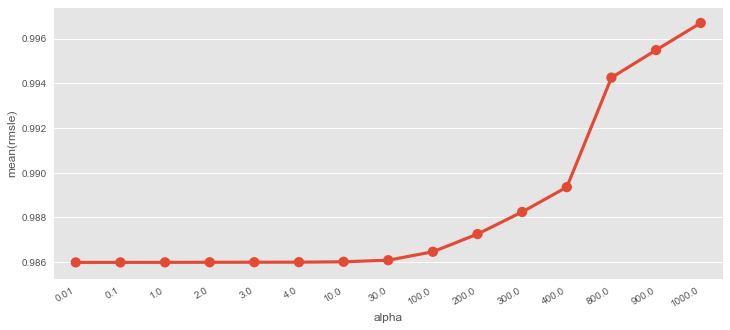

In [37]:
ridge_m_=Ridge()
ridge_params_ = {'max_iter' : [3000],
                'alpha' : [0.01,0.1,1,2,3,4,10,30,100,200,300,400,800,900,1000]}
rmsle_scorer=metrics.make_scorer(rmsle, greater_is_better = False)
grid_ridge_m = GridSearchCV(ridge_m_, ridge_params_,
                           scoring=rmsle_scorer,cv=5)

y_train_log=np.log1p(y_train)
grid_ridge_m.fit(X_train, y_train_log)
preds = grid_ridge_m.predict(X_train)
print(grid_ridge_m.best_params_)
print("RMSLE Value For Ridge Regression: ",
     rmsle(np.exp(y_train_log),np.exp(preds),False))

fig,ax=plt.subplots()
fig.set_size_inches(12,5)
df=pd.DataFrame(grid_ridge_m.grid_scores_)
df["alpha"] = df["parameters"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_validation_score"].apply(lambda x:-x)

plt.xticks(rotation =30, ha ="right")
sns.pointplot(data=df, x="alpha", y ="rmsle", ax=ax)

# 라쏘 Regularization Model - Lasso 

* 선형회귀의 Regularization(규제)을 적용하는 대안
* 계수를 0에 가깝게 만들려고 하며 이를 L1 규제라고 하며, 어떤 계수는 0이 되기도 하는데 이는 완전히 제외하는 피처가 생긴다는 의미다. 
* 피처 선택이 자동으로 이루어진다고도 볼 수 있다.
* alpha 값이 기본값은 0.1 이며 과소적합을 줄이기 위해서는 이 값을 줄여야 한다.
* 그리드 서치로 아래 라쏘모델을 실행했을 때 베스트 알파 값은 0.0025
* max_iter (반복실행하는 최대 횟수)는 3000을 넣어주었다.

{'alpha': 0.0050000000000000001, 'max_iter': 3000}
RMSLE Value For Lasso Regression:  0.9786730688


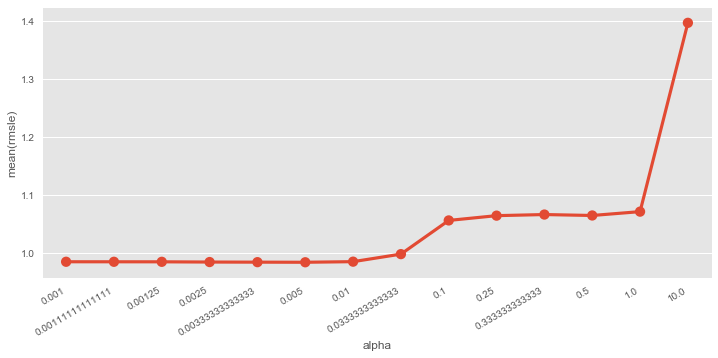

In [38]:
lasso_m_ = Lasso()

alpha = 1/np.array([0.1,1,2,3,4,10,30,100,200,300,400,800,900,1000])
lasso_params_ = {'max_iter' : [3000],
                'alpha' : alpha}

grid_lasso_m = GridSearchCV(lasso_m_ , lasso_params_, scoring =rmsle_scorer,cv=5)
y_train_log=np.log1p(y_train)
grid_lasso_m.fit(X_train,y_train_log)
preds = grid_lasso_m.predict(X_train)
print(grid_lasso_m.best_params_)
print ("RMSLE Value For Lasso Regression: ",rmsle(np.exp(y_train_log),np.exp(preds),False))

fig,ax= plt.subplots()
fig.set_size_inches(12,5)
df = pd.DataFrame(grid_lasso_m.grid_scores_)
df["alpha"] = df["parameters"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_validation_score"].apply(lambda x:-x)

plt.xticks(rotation=30, ha='right')
sns.pointplot(data=df,x="alpha",y="rmsle",ax=ax)
    

# 앙상블모델 - 랜덤포레스트

## Ensemble Models - Random Forest

In [44]:
from sklearn.ensemble import RandomForestRegressor
rfModel = RandomForestRegressor(n_estimators=100)

y_train_log = np.log1p(y_train)
rfModel.fit(X_train, y_train_log)

preds = rfModel.predict(X_train)
score = rmsle(np.exp(y_train_log),np.exp(preds),False)
print ("RMSLE Value For Random Forest: ",score)

RMSLE Value For Random Forest:  0.102941765527


# 앙상블모델 - 그라디언트 부스트

## Ensemble Model - Gradient Boost

* 여러 개의 결정 트리를 묶어 강력한 모델을 만드는 또 다른 앙상블 기법
* 회귀와 분류에 모두 사용할 수 있음
* 랜덤포레스트와 달리 이진 트리의 오차를 보완하는 방식으로 순차적으로 트리를 만든다.
* 무작위성이 없고 강력한 사전 가지치기가 사용됨
* 1~5개의 깊지 않은 트리를 사용하기 때문에 메모리를 적게 사용하고 예측이 빠름
* learning_rate : 오차를 얼마나 강하게 보정할 것인지를 제어
* n_estimator의 값을 키우면 앙상블에 트리가 더 많이 추가되어 모델의 복잡도가 커지고 훈련 세트에서의 실수를 바로잡을 기회가 많아지지만, 너무 크면 모델이 복잡해지고 오버피팅(과대적합)이 될 수 있다.
* max_depth(max_leaf_nodes) 복잡도를 너무 높이지 말고 트리의 깊이가 5보다 깊어지지 않게 한다.

In [40]:
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor(n_estimators=4000, alpha=0.01);

y_train_log = np.log1p(y_train)
gbm.fit(X_train, y_train_log)

preds = gbm.predict(X_train)
score = rmsle(np.exp(y_train_log),np.exp(preds),False)
print ("RMSLE Value For Gradient Boost: ", score)

RMSLE Value For Gradient Boost:  0.20182369393


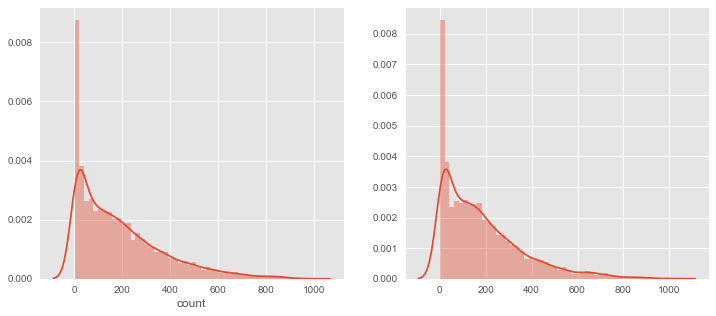

In [41]:
predsTest = gbm.predict(X_test)
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_train,ax=ax1,bins=50)
sns.distplot(np.exp(predsTest),ax=ax2,bins=50)

# Submit

In [45]:
submission = pd.read_csv("data/sampleSubmission.csv")
submission

submission["count"] = np.exp(predsTest)

print(submission.shape)
submission.head()

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,9.700863
1,2011-01-20 01:00:00,5.516343
2,2011-01-20 02:00:00,3.721906
3,2011-01-20 03:00:00,2.647233
4,2011-01-20 04:00:00,2.228796


In [46]:
submission.to_csv("data/Score_{0:.5f}_submission.csv".format(score), index=False)